# Kelly Criterion for Investment Size

In [1]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dy
from pylab import plt, mpl

In [5]:
np.random.seed(1000)
plt.style.use('seaborn-v0_8-dark')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [7]:
# Probability of Positive Scenario
p = 0.55

In [8]:
# Optimal Fraction
f = p - (1 - p)
f

0.10000000000000009

In [9]:
I = 50 # Number of series to simulate
n = 100 # Number of trials per series

In [10]:
def run_simulation(f):
    c = np.zeros((n, I)) # n-dimensional array to store simulation results
    c[0] = 100 # starting balance
    for i in range(I):
        for t in range(1, n):
            o = np.random.binomial(1, p) # simulates tossing a coin with 55-45 pct
            if o > 0:
                c[t,i] = (1 + f) * c[t-1, i] # Adds winnings to capital (betting f % of avail balance)
            else:
                c[t,i] = (1 - f) * c[t-1, i] # Subtracts losses to capital (betting f % of avail balance)
    return c

In [11]:
c_1 = run_simulation(f)

In [12]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]],
      shape=(100, 50))

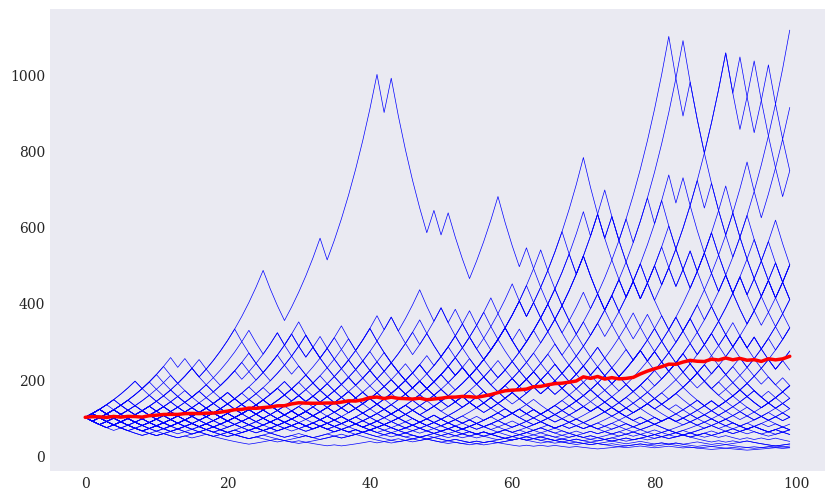

In [13]:
plt.figure(figsize=(10,6))
plt.plot(c_1, 'b', lw=0.5) # plots all of the 50 series
plt.plot(c_1.mean(axis=1), 'r', lw=2.5) # plots the average of all 50 series

In [14]:
c_2 = run_simulation(0.05)
c_3 = run_simulation(0.25)
c_4 = run_simulation(0.5)

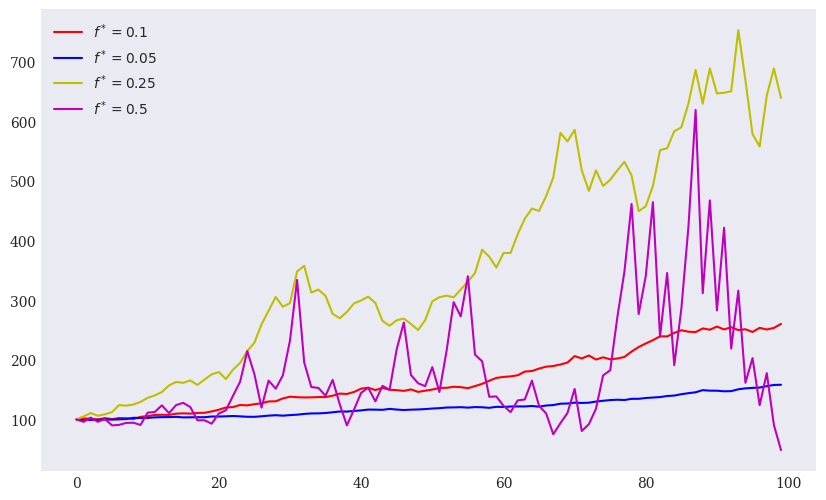

In [16]:
plt.figure(figsize=(10,6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f^*=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f^*=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f^*=0.5$')
plt.legend(loc=0)

# Kelly Criterion for Stocks and Indices

In [17]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True)

In [18]:
symbol = '.SPX'

In [19]:
data = pd.DataFrame(raw[symbol])

In [20]:
data['return'] = np.log(data/data.shift(1))

In [21]:
data.dropna(inplace=True)

In [22]:
data.tail()

,.SPX,return
Date,,
2019-12-23,3224.01,0.000866
2019-12-24,3223.38,-0.000195
2019-12-27,3240.02,0.000034
2019-12-30,3221.29,-0.005798
2019-12-31,3230.78,0.002942


In [23]:
mu = data['return'].mean() * 252 # cacluate the annualized return

In [24]:
mu

np.float64(0.09992181916534204)

In [26]:
sigma = data['return'].std() * 252 ** 0.5 # Caculates the annualized volatility

In [27]:
sigma

np.float64(0.14761569775486563)

In [28]:
r = 0.0 # sets the risk free rate to 0 for simplicity

In [30]:
f = (mu - r) / sigma ** 2 # determines optimal kelly fraction to be invested
f

np.float64(4.585590244019818)

This kelly optimal fraction of 4.5 indicates investing $4.5 for every dollar available for long positions \
This implies a leverage ratio of 4.5

## Applying Kelly Criterion and Optimal Leverage Ratio

In [32]:
equs = []
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1 # Generates a new column for equity and sets initially to 1
    data[cap] = data[equ] * f # Generates new column for capital, sets to 1 * f^*
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['return'].loc[t]) # Calculates new capital position given the return
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
                            data[equ].loc[t_1] # Adjust equity according to capital position performance
        data.loc[t, cap] = data[equ].loc[t] * f # adjusts the capital position given new equity and fixed leverage ratio

In [33]:
kelly_strategy(f * 0.5) # half of optimal leverage

/var/folders/cs/5m2r1zrd2l3dgt4qypzbm9_80000gn/T/ipykernel_8869/3846821912.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0012507769116654' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[t, equ] = data[cap].loc[t] - \


In [34]:
kelly_strategy(f * 0.66) # 2/3 of optimal leverage

/var/folders/cs/5m2r1zrd2l3dgt4qypzbm9_80000gn/T/ipykernel_8869/3846821912.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0016510255233988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[t, equ] = data[cap].loc[t] - \


In [35]:
kelly_strategy(f) # full leverage

/var/folders/cs/5m2r1zrd2l3dgt4qypzbm9_80000gn/T/ipykernel_8869/3846821912.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0025015538233308' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[t, equ] = data[cap].loc[t] - \


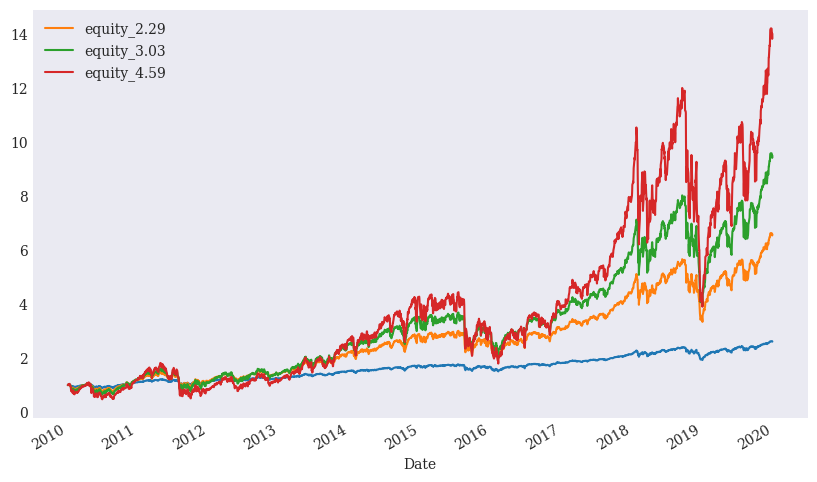

In [36]:
ax = data['return'].cumsum().apply(np.exp).plot(figsize=(10, 6))
data[equs].plot(ax=ax, legend=True);

In [ ]:
# Optimal Kelly Leverage leads to high volatility which is intuitive since it is 4.59 per 1 dollar
# practioners often use half kelly instead to reduce volatility

# ML + OANDA (not using oanda since it requires sign up and SSN)

# Risk Analysis